# Subgraph Implementation

## Define State

In [1]:
from typing import Annotated, List
from typing_extensions import TypedDict
import operator

from langchain_core.messages import AnyMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, START, END

class SubGraphState(TypedDict):
    messages: Annotated[List[AnyMessage], operator.add] # message history
    context: str


## Node Functions

In [2]:
def process_node(state: SubGraphState):
    current_message = state["messages"][-1]
    processed_result = f"Processed: {current_message.content}"
    return {"context": processed_result}

def respond_node(state: SubGraphState):
    context = state["context"]
    response = AIMessage(content=f"Response based on: {context}")
    return {"messages": [response]}

## Construct Subgraph

In [3]:
subgraph = StateGraph(SubGraphState)

subgraph.add_node("process", process_node)
subgraph.add_node("respond", respond_node)

subgraph.add_edge(START, "process")
subgraph.add_edge("process", "respond")
subgraph.add_edge("respond", END)

compiled_subgraph = subgraph.compile()


## Visualize Subgraph

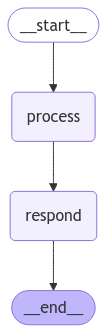

In [4]:
from IPython.display import Image, display

subgraph_image = compiled_subgraph.get_graph().draw_mermaid_png()
display(Image(subgraph_image))


## Run Subgraph

In [5]:
initial_state = {
    "messages": [HumanMessage(content="Hello!")],
    "context": ""
}

result = compiled_subgraph.invoke(initial_state)

for message in result["messages"]:
    print(f"Message: {message.content}")


Message: Hello!
Message: Response based on: Processed: Hello!


# Integrate into Main 

## Define State

In [6]:
from typing import Annotated, Optional, TypedDict, Literal, List
from langgraph.graph import StateGraph, START, END

class MainState(TypedDict):
    messages: Annotated[List[AnyMessage], operator.add]
    context: str
    subgraph_result: Optional[str]
    processing_status: str


## Node Functions

In [7]:
def preprocessing(state: MainState): # -> MainState:
    return {
        "context": f"Context from: {state['messages'][-1].content}",
        "processing_status": "preprocessing_complete"
    }

def postprocessing(state: MainState): # -> MainState:
    context = state.get("context", "")
    return {
        "subgraph_result": f"Fianl result based in context: {context}",
        "processing_status": "complete"
    }


## Routing Logic

In [8]:
def route_next(state: MainState) -> Literal["postprocessing", "reprocess"]:
    if state["processing_status"] == "preprocessing_complete":
        return "postprocessing"
    return "reprocess"


## Construct Graph

In [9]:
main_graph = StateGraph(MainState)

main_graph.add_node("preprocessing", preprocessing)
main_graph.add_node("subgraph", subgraph.compile())
main_graph.add_node("postprocessing", postprocessing)

main_graph.add_edge(START, "preprocessing")
main_graph.add_edge("preprocessing", "subgraph")
main_graph.add_conditional_edges(
    "subgraph",
    route_next,
    {
        "postprocessing": "postprocessing",
        "reprocess": "preprocessing"
    }
)
main_graph.add_edge("postprocessing", END)

compiled_maingraph = main_graph.compile()


## Visualize Subgraph

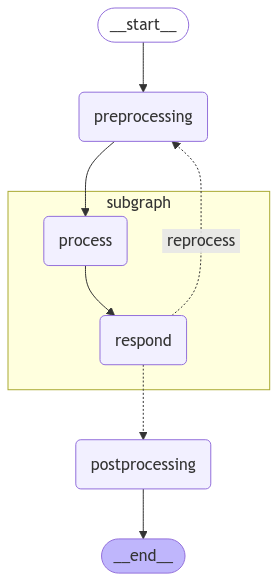

In [11]:
from IPython.display import Image, display

maingraph_image = compiled_maingraph.get_graph(xray=True).draw_mermaid_png()
display(Image(maingraph_image))


## Run Subgraph

In [12]:
initial_state = {
    "messages": [HumanMessage(content="Hello!")],
    "processing_status": "started"
}

try:
   result = compiled_maingraph.invoke(initial_state)
   print("실행 결과:")
   print(f"처리 상태: {result['processing_status']}")
   print(f"최종 결과: {result['subgraph_result']}")
except Exception as e:
   print(f"그래프 실행 실패: {e}")


실행 결과:
처리 상태: complete
최종 결과: Fianl result based in context: Processed: Hello!
